<a id='Top'></a>
# UNSUPERVISED CHALLENGE

© Explore Data Science Academy

---

# Team JM4 Unsupervised Predict Notebook

---
<img src="img/predict bg.png" align="left">


<a id="cont"></a>

## Table of Contents

## <a href=#one>1. Introduction</a>
* <a href=#problemstament>1.1 Problem Statement</a>
* <a href=#po>1.2 Project Objectives</a>
* <a href=#dotrain_eda>1.3 Data Overview</a>
* <a href=#StartingaCometexperiment>1.4 Starting a Comet experiment</a>

## <a href=#two>2. Import Necessary Libraries</a>

## <a href=#three>3. Loading Datasets</a>
* <a href=#three1>3.1 Set Pandas to enable viewing of all columns</a>
* <a href=#three2>3.2 Check the "Shape" of the data-sets</a>
* <a href=#three21>3.3 Use the ".column" function to view the columns in our data set</a>

## <a href=#four>4. Data Preprocessing (Cleaning)</a>
* <a href=#four1>4.1 Identifying Missing Values</a>
* <a href=#four2>4.2 Preprocessing the Dataset</a>
<!-- * <a href=#four3>4.3 Most Common Words</a> -->

## <a href=#five>5. Exploratory Data Analysis (EDA)</a>



 <a id="one"></a>
## 1. INTRODUCTION
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Project Overview ⚡ |
| :--------------------------- |
| We will address the problem statement and objectives, as well as the classification of data aspects and a brief discussion of the Movie Recomender System in this part.|

<a id="top"></a>
- Recommender systems are economically and socially essential in today's technologically advanced world for enabling people to make wise decisions about the information they consume on a daily basis. This is particularly true in the area of movie content suggestions, where clever algorithms may guide viewers toward excellent films among tens of thousands of possibilities.

- We will build a recommendation system based on collaborative filtering or content that will be capable of effectively predicting how a user would rate a film they haven't yet seen based on their past preferences..

- With users of the system being exposed to content they would like to watch or buy, the provision of an accurate and robust solution to this problem has enormous economic potential, creating income and platform loyalty.
---



 <a id="problemstament"></a> 
 
### 1.1 Problem Statement

Our team has been charged with developing a collaborative filtering or content-based recommendation system that can precisely anticipate how a user would score a movie they haven't yet seen based on their prior preferences.

<a id="po"></a>

### 1.2 Project Objectives

* examine the data provided, find any probable flaws, and clean the current data set

* ascertain whether further characteristics may be included to improve the data set

* create a model that can forecast how a consumer would evaluate a film

* assess the best machine learning model's accuracy

* using a user's previous choices to forecast with accuracy how they would evaluate a movie they haven't yet seen

* Describe the model's inner workings to a non-technical audience.

<a id="dodf"></a>

### 1.3 Data Overview

Millions of users of the online MovieLens movie recommendation service provided their 5-star ratings for this dataset, which comprises of several million ratings. In order to enhance the functionality of explicitly-based recommender systems, business and academic researchers have long used the MovieLens dataset. 

We'll be utilizing an enhanced, resampled, and unique version of the Movies dataset for this Predict in order to conduct a fair evaluation.

#### I. Supplied Files
* genome_scores.csv: a rating indicating how well movies match certain tag-related qualities.

* genome_tags.csv: user-assigned tags for scores connected to the genome

* imdb_data.csv: Using the links.csv file, more movie metadata is extracted from IMDB.

* links.csv: File supplying a mapping between a related IMDB ID and TMDB ID and a Movies ID.

* tags.csv: For each movie in the collection, a user-assigned number.

* test.csv: The test split of the dataset. Contains user and movie IDs with no rating data.

* train.csv: The dataset's training segment. Contains user and movie IDs and the ratings that go with them.


>#### Additional Information
The below information is provided directly from the Movies dataset description files:

### Ratings Data File Structure (train.csv)
- The train.csv file contains all ratings. Following the header row, each line of this file contains one user's rating of one movie, in the following format:
    - userId
    - movieId
    - rating
    - timestamp

- Within this file, the lines are arranged by userId first, then within user, by movieId.

- A 5-star rating system is used, with half-star increments (0.5 stars - 5.0 stars).

- Timestamps are seconds since midnight on January 1, 1970, Coordinated Universal Time (UTC).

### Tags Data File Structure (tags.csv)
- The file tags.csv contains all of the tags. After the header row, each line in this file indicates a tag a user has applied to a particular video, and it is formatted as follows:
    - userId
    - movieId
    - tag
    - timestamp

- Within this file, the lines are arranged by userId first, then within user, by movieId.

- User-generated metadata about movies is created using tags. Typically, each tag consists of a single word or brief sentence. Each user decides what a given tag means, is worth, and serves for.

- Timestamps show seconds since midnight on January 1, 1970, Coordinated Universal Time (UTC).

### Movies Data File Structure (movies.csv)
- The movies.csv file contains movie-related data. Following the header row, each line in this file represents a single movie and is formatted as follows:
    - movieId
    - title
    - genres

- Genres are a pipe-separated list, and are selected from the following:
    - Action
    - Adventure
    - Animation
    - Children's
    - Comedy
    - Crime
    - Documentary
    - Drama
    - Fantasy
    - Film-Noir
    - Horror
    - Musical
    - Mystery
    - Romance
    - Sci-Fi
    - Thriller
    - War
    - Western
    (no genres listed)

### Links Data File Structure (links.csv)
- The file links.csv contains identifiers that may be used to link to various sources of movie data. This file's lines after the header row represent individual movies and are formatted as follows:
    - movieId
    - imdbId
    - tmdbId

- movieId is the movie identification that https://movies.org uses. For instance, https://movielens.org/movies/1 provides a link to the movie Toy Story.

- The movie identification used by http://www.imdb.com is called imdbId. Toy Story, for instance, may be found at http://www.imdb.com/title/tt0114709.

- tmdb

- Id is the movie identification that https://www.themoviedb.org uses. Toy Story, for instance, may be found at https://www.themoviedb.org/movie/862.

### Tag Genome (genome-scores.csv and genome-tags.csv)
- As previously mentioned, the tag genome encodes the degree to which movies display specific characteristics that are denoted by tags (atmospheric, thought-provoking, realistic, etc.). Using a machine learning algorithm on user-generated content, such as tags, ratings, and textual reviews, the tag genome was calculated.
- Two files make up the genome. Movie-tag relevance information is presented in the following way in the file genome-scores.csv:
    - movieId
    - tagId
    - relevance
- The tag descriptions for the tag IDs in the genome file are provided in the second file, genome-tags.csv, in the following format:
    - tagId
    - tag

<a id="StartingaCometexperiment"></a>

### 1.4 Starting a Comet Experiment
<img src="https://www.comet.ml/images/logo_comet_light.png" width="350" alt="Drawing" style="width: 350px;"/>

- Comet offers data scientists and teams a self-hosted and cloud-based meta machine learning platform that enables tracking, comparing, explanatory, and model optimization.

- Comet offers insights and data to construct stronger, more accurate AI models while enhancing productivity, collaboration, and visibility across teams. Comet is supported by thousands of users and several Fortune 100 firms.
- Comet will be used by us to version control our research.

In [1]:
import os
os.environ["COMET_URL_OVERRIDE"] = "https://www.comet.com/clientlib/"
from comet_ml import Experiment

In [2]:
# # Creating an experiment with your api key
# experiment = Experiment(
#     api_key="bEFY9Hn1QccermEDT6aTyQMOA",
#     project_name="jm4",
#     workspace="kojosbk",
# )

 <a id="two"></a>
## 2. Import Necessary Libraries
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Import necessary libraries ⚡ |
| :--------------------------- |
| We'd be importing all of the necessary libraries for the notebook to run smoothly..|



In [3]:
# Libraries for importing and loading data
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import seaborn as sns
from textwrap import wrap
import pickle

#visualization libraries
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Entity featurization and similarity computation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Data Preprocessing
import random
from time import time
import cufflinks as cf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Models
from surprise import Reader, Dataset
from surprise import SVD, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering
from sklearn.metrics.pairwise import cosine_similarity


# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Setting global constants to ensure notebook results are reproducible

RANDOM_STATE = 42


import warnings
warnings.filterwarnings('ignore')


<a id="Three"></a>
## 3. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| The data from the `train` file is loaded into a DataFrame in this section.. |

---

#### - Train and test data:
For training and Kaggle submission purposes, this data is used. The target variable is rating.

In [4]:
# load the data
#Note : the data souce is saved in another directory of the local machine  to avoid github Push issues
train = pd.read_csv('C:/Users/Silas_Dell/Documents/Programming/Explore/Unsupervised learning/data/train.csv')
test = pd.read_csv('C:/Users/Silas_Dell/Documents/Programming/Explore/Unsupervised learning/data/test.csv')

In [5]:
# load the  Movie Data
#Note : the Movie Data data souce is saved in another directory of the local machine  to avoid github Push issues
genome_scores = pd.read_csv('C:/Users/Silas_Dell/Documents/Programming/Explore/Unsupervised learning/data/genome_scores.csv')
genome_tags = pd.read_csv('C:/Users/Silas_Dell/Documents/Programming/Explore/Unsupervised learning/data/tags.csv')
imdb_data = pd.read_csv('C:/Users/Silas_Dell/Documents/Programming/Explore/Unsupervised learning/data/imdb_data.csv')
links = pd.read_csv('C:/Users/Silas_Dell/Documents/Programming/Explore/Unsupervised learning/data/links.csv')
movies = pd.read_csv('C:/Users/Silas_Dell/Documents/Programming/Explore/Unsupervised learning/data/movies.csv')
tags = pd.read_csv('C:/Users/Silas_Dell/Documents/Programming/Explore/Unsupervised learning/data/tags.csv')

<a id=three1></a>

#### 3.1 Set Pandas to enable viewing of all columns
Due to the length of th content of the message column, pandas cannot display all of them at once by default. While doing EDA and data cleansing, we will need to see all of the columns. When the dataframe is presented, the code below allows us to see the whole set of columns in our data collection. 

In [6]:
# Set option to display all columns
pd.set_option('display.max_colwidth', None)

<a id=three2></a>

#### 3.2 Check the "Shape" of the data-sets
As demonstrated by the shape of both datasets, the data has been separated into two sets. The form also shows that the training data set has four columns, but the test data set has just two. Our model is designed to forecast the column that is named movieID.

In [7]:
# Preview train dataset
print('The Shape of the data is: ', train.shape)
train.head()

The Shape of the data is:  (10000038, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


It should be noticed that the train data also includes a column called "timestamp." This information may be safely ignored because there is no connection between when someone watches a movie and whether or not they like it.

In [8]:
# Preview test dataset
print('The Shape of the data is: ', test.shape)
test.head()

The Shape of the data is:  (5000019, 2)


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [9]:
# Preview genome_scores dataset
print('The Shape of the data is: ', genome_scores.shape)
genome_scores.head()

The Shape of the data is:  (15584448, 3)


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [10]:
# Preview genome_tags dataset
print('The Shape of the data is: ', genome_tags.shape)
genome_tags.head()

The Shape of the data is:  (1093360, 4)


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [11]:
# Preview imdb_data dataset
print('The Shape of the data is: ', imdb_data.shape)
imdb_data.head()

The Shape of the data is:  (27278, 6)


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wallace Shawn|John Ratzenberger|Annie Potts|John Morris|Erik von Detten|Laurie Metcalf|R. Lee Ermey|Sarah Freeman|Penn Jillette|Jack Angel|Spencer Aste,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bradley Pierce|Bonnie Hunt|Bebe Neuwirth|David Alan Grier|Patricia Clarkson|Adam Hann-Byrd|Laura Bell Bundy|James Handy|Gillian Barber|Brandon Obray|Cyrus Thiedeke|Gary Joseph Thorup,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Margret|Burgess Meredith|Daryl Hannah|Kevin Pollak|Katie Sagona|Ann Morgan Guilbert|James Andelin|Marcus Klemp|Max Wright|Cheryl Hawker|Wayne A. Evenson|Allison Levine,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|Lela Rochon|Gregory Hines|Dennis Haysbert|Mykelti Williamson|Michael Beach|Leon|Wendell Pierce|Donald Faison|Jeffrey D. Sams|Jazz Raycole|Brandon Hammond|Kenya Moore,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betrayal|mother son relationship
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberly Williams-Paisley|George Newbern|Kieran Culkin|BD Wong|Peter Michael Goetz|Kate McGregor-Stewart|Jane Adams|Eugene Levy|Rebecca Chambers|April Ortiz|Dulcy Rogers|Kathy Anthony,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [12]:
# Preview links dataset
print('The Shape of the data is: ', links.shape)
links.head()

The Shape of the data is:  (62423, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
# Preview movies dataset
print('The Shape of the data is: ', movies.shape)
movies.head()

The Shape of the data is:  (62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
# Preview tags dataset
print('The Shape of the data is: ', tags.shape)
tags.head()

The Shape of the data is:  (1093360, 4)


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


<a id="five"></a>
## 4. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In order to achieve the needed answers, uncover trends, patterns, and correlations that are not immediately obvious, or to get insights into the dataset, we will be analyzing and studying the data sets in this part. |

---

Exploratory data analysis is a way of studying data sets to highlight their key features, frequently using visual techniques. The crucial process of conducting early investigations on data using summary statistics and graphical representations to find trends, identify anomalies, test hypotheses, and verify assumptions.

EDA is primarily used to see what the data can tell us beyond the formal modeling or hypothesis testing work, regardless of whether a statistical model is utilized.

<a id=four1></a>

#### 5.1 Dataset summary
It is important to identify the columns that have null entries as null values can affect the performance of our model. The "isnull" function shows the number of null values that are contained in each column of the dataset. This data set is relatively clean 
Pandas dataframe.info() function is used to get a concise summary of the dataframe

In [15]:
def Summary(df):
    i = df.info()
    print ("NUL Values")
    n = df.isna().sum()
    return i,n

In [16]:
Summary(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
NUL Values


(None,
 userId       0
 movieId      0
 rating       0
 timestamp    0
 dtype: int64)

In [17]:
Summary(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB
NUL Values


(None,
 userId     0
 movieId    0
 dtype: int64)

In [18]:
Summary(tags)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB
NUL Values


(None,
 userId        0
 movieId       0
 tag          16
 timestamp     0
 dtype: int64)

In [19]:
Summary(movies)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
NUL Values


(None,
 movieId    0
 title      0
 genres     0
 dtype: int64)

In [20]:
Summary(links)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB
NUL Values


(None,
 movieId      0
 imdbId       0
 tmdbId     107
 dtype: int64)

In [21]:
Summary(imdb_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB
NUL Values


(None,
 movieId              0
 title_cast       10068
 director          9874
 runtime          12089
 budget           19372
 plot_keywords    11078
 dtype: int64)

In [22]:
Summary(genome_tags)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB
NUL Values


(None,
 userId        0
 movieId       0
 tag          16
 timestamp     0
 dtype: int64)

In [23]:
Summary(genome_scores)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB
NUL Values


(None,
 movieId      0
 tagId        0
 relevance    0
 dtype: int64)

#### Observations
The Dtype of int64 and float64, which is a sign of numeric values, is present in the majority of DataFrames. However, some DataFrames additionally feature an object's Dtype, which indicates a character other than a numeric character. The DataFrames tags df, movies df, imdb df, and genome df all have a Dtype.

### 5.2 Visualizing the dataframes

In [24]:
# Created a Data Frame outlining the size of our data
dataframes = ['train', 'test', 'tags', 'imdb',
              'links', 'movies', 'genome_tags', 'genome_score']
sizes = [(train.shape[0]), (test.shape[0]), (tags.shape[0]),
         (imdb_data.shape[0]), (links.shape[0]), (movies.shape[0]),
         (genome_tags.shape[0]), (genome_scores.shape[0])]
total_size = pd.DataFrame(list(zip(dataframes, sizes)),
                             columns=['dataframe', 'sizes'])
total_size

,dataframe,sizes
0,train,10000038
1,test,5000019
2,tags,1093360
3,imdb,27278
4,links,62423
5,movies,62423
6,genome_tags,1093360
7,genome_score,15584448


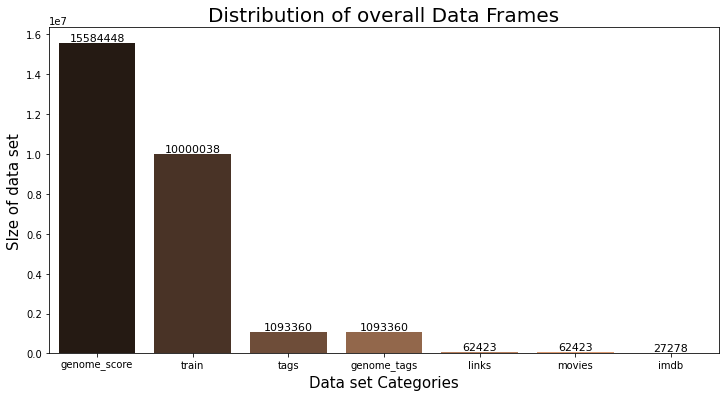

In [25]:
len_list = [['train', (train.shape[0])], ['tags', (tags.shape[0])],
            ['imdb', (imdb_data.shape[0])], ['links', (links.shape[0])],
            ['movies', (movies.shape[0])],
            ['genome_tags', (genome_tags.shape[0])],
            ['genome_score', (genome_scores.shape[0])]]
len = pd.DataFrame(len_list,
                      columns=['Dataset', 'Size'])
len = len.sort_values(by='Size', ascending=False)
fig, ax = plt.subplots( figsize=(12,6))
ax = sns.barplot(y =  len["Size"], x = len["Dataset"], palette='copper')
for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
ax.set_xlabel("Data set Categories", fontsize = 15)
ax.set_ylabel("SIze of data set", fontsize = 15)
ax.set_title("Distribution of overall Data Frames", fontsize = 20)
plt.show()

In [26]:
len_list = [['train', (train.shape[0])], ['tags', (tags.shape[0])],
            ['imdb', (imdb_data.shape[0])], ['links', (links.shape[0])],
            ['movies', (movies.shape[0])],
            ['genome_tags', (genome_tags.shape[0])],
            ['genome_score', (genome_scores.shape[0])]]
len = pd.DataFrame(len_list,
                      columns=['Dataset', 'Size'])
fig = px.treemap(len, title='Treemap chart by Distribution of overall Data Frames',
                 path=["Dataset"], values = 'Size',color='Size', color_continuous_scale=px.colors.sequential.GnBu)
fig.show()

#### Observations
The precise asymmetry in DataFrame size distribution is shown in the bar graph. The biggest DataFrame is the genome score DataFrame, followed by the train Dataframe. Whereas the bars in the other DataFrame are not readily visible due to the significant disparity in the dimensions, the difference in distribution sizes is obvious as shown in the treemap.

#### 5.2 Movies produced per Year
In this section, we're curious to learn which years had the greatest amount of films made. We may use this information to graphically examine historical performance of the film business.

In [27]:
# Make a copy of movie table
movies_table = movies.copy()

# Remove delimiters from interested columns
movies_table["genres"] = movies_table["genres"].str.replace('|', ' ', regex=True)
movies_table["title"] = movies_table["title"].str.replace('(', ' ', regex=True)
movies_table["title"] = movies_table["title"].str.replace('$', ' ', regex=True)
movies_table["title"] = movies_table["title"].str.replace(')', ' ', regex=True)
movies_table["genres"] = movies_table["genres"].str.replace('(', ' ', regex=True)
movies_table["genres"] = movies_table["genres"].str.replace(')', ' ', regex=True)
# Create a movie year column
movies_table["year"] = movies_table["title"].str.replace(r'[a-zA-Z]', '', regex=True)
movies_table["year"] = movies_table["year"].str.replace(r' ', '', regex=True)
movies_table.head()

,movieId,title,genres,year
0,1,Toy Story 1995,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji 1995,Adventure Children Fantasy,1995
2,3,Grumpier Old Men 1995,Comedy Romance,1995
3,4,Waiting to Exhale 1995,Comedy Drama Romance,1995
4,5,Father of the Bride Part II 1995,Comedy,1995


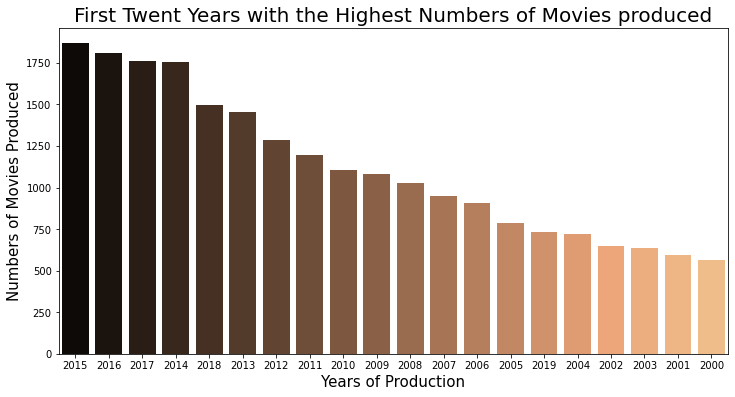

In [28]:
# Visualise the first twenty years with the highest numbers of movies produced
movies_table["year"] = movies_table["year"].astype('str')
movies_year_count = movies_table["year"].value_counts()
fig, ax = plt.subplots( figsize=(12,6))
ax = sns.barplot(y =  movies_year_count.values[:20], x = movies_year_count.index[:20], palette='copper')
ax.set_xlabel("Years of Production", fontsize = 15)
ax.set_ylabel("Numbers of Movies Produced", fontsize = 15)
ax.set_title("First Twent Years with the Highest Numbers of Movies produced", fontsize = 20)
plt.show()

#### Quick Observations
* The year 2015 had the largest number of films created, with over 1700. It was followed by the years 2016 and 2017, which both saw over 1500 films produced.

* One thing to note is that a year like 2019 would have been expected to have a lot of movies released, but due to the outbreak of COVID 19, we observe a decline in movie releases in the year 2019.

#### 5.3 Top Rated Movies

For this area, we need to know which films have received a rating of 4 or above. Less than a 4 was seen to be an average rating.

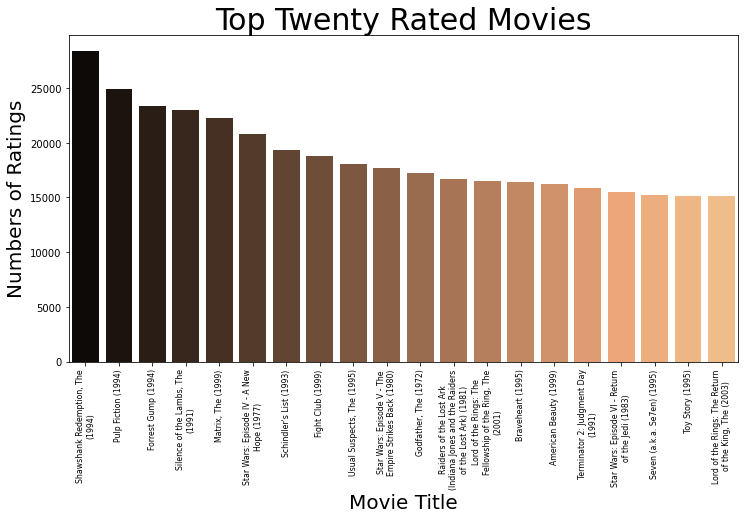

In [29]:
train_table = train.copy()
train_table.drop(columns='timestamp', inplace=True)
ratings = train_table[['movieId','rating']]
ratings = ratings[ratings['rating'] > 3.9]
ratings = ratings.merge(movies, on = 'movieId', how= 'left')

movies_ratings = ratings['title'].value_counts()

labels = [ '\n'.join(wrap(l, 30)) for l in movies_ratings.index[:20]]



fig, ax = plt.subplots( figsize=(12,6))
ax = sns.barplot(y =  movies_ratings.values[:20], x = labels, palette='copper')
ax.set_xlabel("Movie Title", fontsize = 20)
ax.set_ylabel("Numbers of Ratings", fontsize = 20)
ax.set_title("Top Twenty Rated Movies", fontsize = 30)
plt.xticks(rotation=90, fontsize= 7.7)
plt.show()


### key point to note

<p float="left">
  <img src="https://www.themoviedb.org/t/p/w500/q6y0Go1tsGEsmtFryDOJo3dEmqu.jpg" width="300" height = 400/>
  <img src="https://cdn.europosters.eu/image/750/posters/pulp-fiction-group-i1295.jpg" width="300" height = 400/>
  <img src="https://cps-static.rovicorp.com/2/Rights%20Managed/Belgacom/Forrest%20Gump/_derived_jpg_q90_310x470_m0/ForrestGump_EN.jpg" width="300" height = 400/>
</p>


**Top three Most Rated Movies**
- Shawshank Redemption (1994)
- Pulp Fiction (1994)
- Forrest Gump (1994)

### Actors

In [ ]:
#this code takes over 97min to run for an i5 8th gen 12gig ram on a secon run it took
#67min.
"""
The most frequent Actors in a DataFrame may be counted using this code.:
"""
# Creat a dict to store values
imdb_data = imdb_data.dropna(axis=0)
cast_dict = {'title_cast': list(),
                'count': list(),}
# Retrieve a list of all possible genres
print('retrieving features...')
for imdb in range((imdb_data.shape[0])):
    cast = imdb_data['title_cast'].iloc[imdb].split('|')
    for cas in cast:
        if cas not in cast_dict['title_cast']:
            cast_dict['title_cast'].append(cas)
# count the number of occurences of each genre
print('counting...')
for castt in cast_dict['title_cast']:
    count = 0
    for imdb in range((imdb_data.shape[0])):
        cast = imdb_data['title_cast'].iloc[imdb].split('|')
        if castt in cast:
            count += 1
    cast_dict['count'].append(count)
    
    # Calculate metrics
cast = pd.DataFrame(cast_dict)
print('done!')
df = cast.sort_values(by = 'count', ascending=False)


### Visualizing the Actors per movie data

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.barplot(y = df['title_cast'].head(10), x = df['count'], palette='copper', orient='h',edgecolor="black")
plt.title('Number of Movies Per Actor For Top 10 Actors', fontsize=14)
plt.ylabel('Actors')
plt.xlabel('Number of movies')
plt.show()

### Top 3 Movie Actors with Highest Number of movies released

<img height = "238" width = 178 src="https://cdn.britannica.com/77/191077-050-63262B99/Samuel-L-Jackson.jpg" alt="Photo of Tom Hanks" class="GeneratedImage">
<img height = "238" width = 950 src="img\sam.JPG" alt="Movies of Tom Hanks" class="GeneratedImage"></br>
<a href="https://en.wikipedia.org/wiki/Tom_Hanks">Samuel Leroy Jackson </a>  is an American actor. One of the most widely recognized actors of his generation, the films in which he has appeared have collectively grossed over $27 billion worldwide, making him the highest-grossing actor of all time. </a>
</br>
</br>
<img height = "238" width = 178 src="https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcSItxlkc_a8e3O3T59cqB6Uw5iPRY5bJlmr8ZUt0KRPLObKcdTd" alt="Photo of Edward Norton" class="GeneratedImage">
<img height = "238" width = 950 src="img\wilss.jpg" alt="Movies of Bruce Willis" class="GeneratedImage"></br>
<a href="https://en.wikipedia.org/wiki/Bruce_Willis">Bruce Willis</a>  is a famous American actor. In the 1970s, his acting career got its start on an off-Broadway theater. He rose to stardom in a starring role on the comedy-drama series Moonlighting (1985–1989), and he went on to feature in more movies, being known as an action hero for his performances as John McClane in the Die Hard trilogy (1988–2013) and other projects.</a>
</br>
</br>

<img height = "238" width = 178 src="https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcRpa6S_5nG_DBliLGNbMMqx_tSAxqmQqDbK26PsKIdZUPxZT017" alt="Photo of Steve Buscemi" class="GeneratedImage">
<img height = "238" width = 950 src="img\ste.jpg" alt="Movies of Leonardo DiCaprio" class="GeneratedImage"></br>
<a href="https://en.wikipedia.org/wiki/Steve_Buscemi">Steve Buscemi</a> is an American actor and film producer. Known for his work as a leading man in biopics and period films, he is the recipient of numerous accolades, including an Academy Award, a British Academy Film Award, and three Golden Globe Awards.  </a>
</br>
</br>


#### Key point to consider
- Samule l. Jackson, Bruce wills, and Steve Buscemi are the top 3 actors with the most movies released.

- Samule l. Jackson has the most realsed movies at 69

---

### The popularity of the actors is not shown by the above chart, therefore let's compute a mean rating and add it to the data.

In [ ]:
def mean_calc(feat_df, ratings = train, movies = imdb_data, column = 'title_cast'):
    """
    Function to add mean ratings to a DataFrame:
    Parameters
    ----------
        feat_df (DataFrame): input dataframe containing cast data
        ratings (DataFrame): input dataframe containing ratings data
        movies  (DataFrame): input dataframe containing imdb metadata
        column  (object): input colum containing title cast
        
    Returns
    -------
        Mean ratings (DataFrame): output DataFrame

    """
    mean_ratings = pd.DataFrame(ratings.merge(movies, how='left').groupby(['movieId'])['rating'].mean())
    movie_eda = movies.copy()
    movie_eda = movie_eda.join(mean_ratings, on = 'movieId', how = 'left')

    # Exclude missing values
    movie_eda = movie_eda
    movie_eda2 = movie_eda[movie_eda['rating'].notnull()]

    means = []
    for feat in feat_df[f'{column}']:
        mean = round(movie_eda2[movie_eda2[f'{column}'].str.contains(feat)]['rating'].mean(),2)
        means.append(mean)
    return means
cast['mean_rating'] = mean_calc(cast.head(10))
#sorting values via mean ratings
cast.sort_values('mean_rating', ascending=False)

In [111]:
def genre_popularity(df):
    """
    Plots the mean rating per genre.
    Parameters
    ----------
        df (DataFrame): input dataframe containing cast data       
    Returns
    -------
        Graph (histogram): output histogram graph
    """
    count_filt = 20
    plt.figure(figsize=(10,6))
    plot_data = df[df['count']>count_filt].head(10)
    mean = plot_data['mean_rating'].mean()
    min_ = plot_data['mean_rating'].min()
    max_ = plot_data['mean_rating'].max()
    sns.barplot(y = plot_data['title_cast'], x = plot_data['mean_rating'], order = plot_data['title_cast'].head(10), orient='h',palette='copper')
    plt.axvline(x=mean, label = f'mean {round(mean,1)}' , color='blue', lw=1, ls ='--')
    plt.axvline(x=min_, label = f'min {round(min_,1)}' , color='#FF5D32', lw=1, ls = '--')
    plt.axvline(x=max_, label = f'max {max_}' , color='r', lw=1,ls = '--')
    plt.title(f'Mean Rating Per Actor (20+ movies released)', fontsize=14)
    plt.ylabel('Actors')
    plt.xlabel('Mean Rating')
    plt.legend(loc='lower center')
    plt.show()

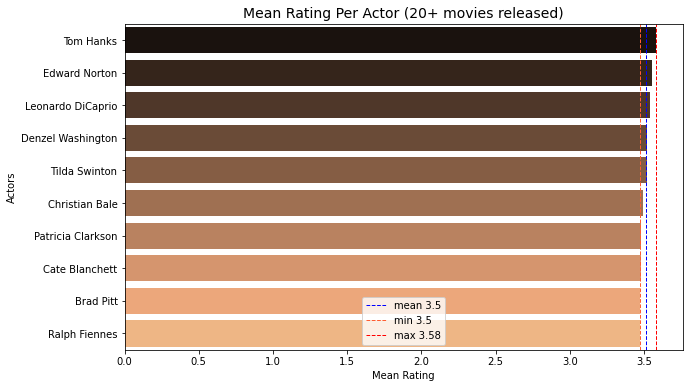

In [112]:
genre_popularity(cast.sort_values('mean_rating', ascending=False))

### Top 3 Movie Actors with High ratings (20+ movies released)

<img height = "238" width = 178 src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS-bt7_ZKFMU8UOOjlq-GYF5P0iNJVuqz9HuDI3GkLmLXDfifpy" alt="Photo of Tom Hanks" class="GeneratedImage">
<img height = "238" width = 950 src="img\2tom_h.JPG" alt="Movies of Tom Hanks" class="GeneratedImage"></br>
<a href="https://en.wikipedia.org/wiki/Tom_Hanks">Tom Hanks</a> is an American actor and filmmaker. Known for both his comedic and dramatic roles, he is one of the most popular and recognizable film stars worldwide, and is regarded as an American cultural icon. </a>
</br>
</br>
<img height = "238" width = 178 src="https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcTWkkwUYKcdK296LMj5-aAkieIrvt7pqfHc4N16BIvL9EHFSpuf" alt="Photo of Edward Norton" class="GeneratedImage">
<img height = "238" width = 950 src="img\tempsnip.png" alt="Movies of Edward Norton" class="GeneratedImage"></br>
<a href="https://en.wikipedia.org/wiki/Edward_Norton">Edward Norton</a> is an American actor and filmmaker. He has received numerous awards and nominations, including a Golden Globe Award and three Academy Award nominations. Born in Boston, Massachusetts and raised in Columbia, Maryland, Norton was drawn to theatrical productions at local venues as a child. </a>
</br>
</br>

<img height = "238" width = 178 src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR2q9tvih6sHPAEEbPoCRrWpf2IWVG5IOo5jIxqCA7dgrggsQO5" alt="Photo of Leonardo DiCaprio" class="GeneratedImage">
<img height = "238" width = 950 src="img\leo.jpg" alt="Movies of Leonardo DiCaprio" class="GeneratedImage"></br>
<a href="https://en.wikipedia.org/wiki/Leonardo_DiCaprio">Leonardo DiCaprio</a> is an American actor and film producer. Known for his work as a leading man in biopics and period films, he is the recipient of numerous accolades, including an Academy Award, a British Academy Film Award, and three Golden Globe Awards.  </a>
</br>
</br>

### Key observatios
* As we can see from the list above, practically every actor is easily identifiable. Naturally, Tom Hanks and Leonardo DiCaprio are at the top of the list.

* The average mean rating of 3.6 for the top 3 actors further indicates how highly moviegoers regard their favorite actors.
---



### Directors

In [125]:
def count_directors(df, count = 10):
    """
    The most frequent directors in a DataFrame may be counted using this function.:
    Parameters
    ----------
        df (DataFrame): dataframe with imdb metadata as input
        count (int): directors with fewer than count films to be filtered
        
    Returns
    -------
        directors (DataFrame): output DataFrame

    """
    directors = pd.DataFrame(df['director'].value_counts()).reset_index()
    directors.columns = ['director', 'count']
    # Lets only take directors who have made 10 or more movies otherwise we will have to analyze 11000 directors
    directors = directors[directors['count']>=count]
    return directors.sort_values('count', ascending = False)
directors = count_directors(imdb_data)

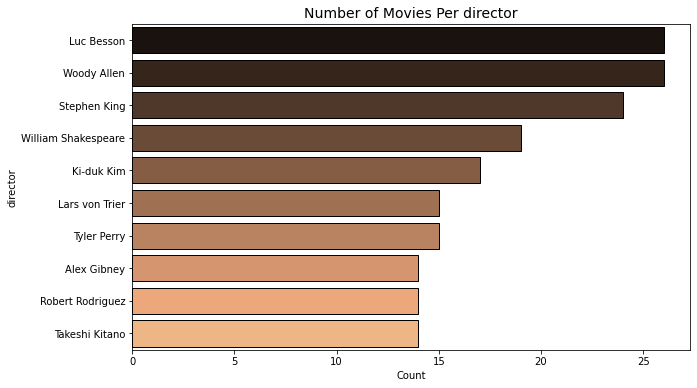

In [126]:
plt.figure(figsize=(10,6))
drt = directors.copy()
drt.drop(drt.index[0], inplace=True)
ax = sns.barplot(y = drt["director"].head(10), x = drt['count'], palette='copper', orient='h', edgecolor="black")
plt.title("Number of Movies Per director", fontsize=14)
plt.ylabel("director")
plt.xlabel('Count')
plt.show()

### Top 3 Directors with most movies released

<img height = "238" width = 178 src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Luc_Besson_by_Gage_Skidmore.jpg/640px-Luc_Besson_by_Gage_Skidmore.jpg" alt="Photo of Luc Besson" class="GeneratedImage">  <img height = "238" width = 950 src="img\luc.JPG" alt="Movies of Tom Hanks" class="GeneratedImage">
</br>
<a href="https://en.wikipedia.org/wiki/Luc_Besson">Luc Paul Maurice Besson</a>  is a French filmmaker, writer, and producer of movies. The Big Blue, La Femme Nikita, and Subway were all movies he either directed or produced. </a>
</br>
</br>
<img height = "238" width = 178 src="https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcQXYKDvhxIVt8R_yV3LLLZJ2LemcV860GqEgu9TKCDvGSDnHksM" alt="Photo of woody allen" class="GeneratedImage"> <img height = "238" width = 950 src="img\woody.JPG" alt="Movies of Tom Hanks" class="GeneratedImage">
</br>
<a href="https://en.wikipedia.org/wiki/Woody_Allen"> Woody Allen</a> is an American filmmaker, writer, actor, and comedian whose career spans more than six decades including several films that have won Academy Awards. </a>
</br>
</br>

<img height = "238" width = 178 src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ3ie6FvZbpJx2VbSMzbGsFagq2wPgnNXJxSPQVTI6ofqhWv28AZKCUZIt54kEQHr9gfiI&usqp=CAU" alt="Photo of Stephen King" class="GeneratedImage"> <img height = "238" width = 950 src="img\king.JPG" alt="Movies of Tom Hanks" class="GeneratedImage"></br>
<a href="https://en.wikipedia.org/wiki/Stephen_King">Stephen King</a>  is an American writer of books in the genres of horror, science fiction, fantasy, suspense, and paranormal fiction. </a>
</br>
</br>


---



#### Once again we need to calculate a mean rating for each director in order to determine who is the most popular

In [127]:
def dir_mean(df):
    df.set_index('director', inplace=True)

    direct_ratings = []
    directors_eda = train.merge(imdb_data, how = 'left')
    for director in df.index:
        rating = round(directors_eda[directors_eda['director']==director]['rating'].mean(),2)
        direct_ratings.append(rating)
    df['mean_rating'] = direct_ratings
    return df.sort_values('mean_rating', ascending = False)
directors = dir_mean(drt)

In [128]:
def feat_popularity(df, title = 'feat'):
    """
    Plots the mean rating per director.
    """
    plt.figure(figsize=(10,6))
    plot_data = df.copy()
    mean = plot_data['mean_rating'].mean()
    min_ = plot_data['mean_rating'].min()
    max_ = round(plot_data['mean_rating'].max(),2)
    sns.barplot(y = plot_data.index, x = plot_data['mean_rating'], order = plot_data.index, orient='h',palette='copper',edgecolor="black")
    plt.axvline(x=mean, label = f'mean {round(mean,1)}' , color='black', lw=1, ls ='--')
    plt.axvline(x=min_, label = f'min {round(min_,1)}' , color='#4D17A0', lw=1, ls = '--')
    plt.axvline(x=max_, label = f'max {max_}' , color='#4DA017', lw=1,ls = '--')
    plt.title(f'Mean Rating Per {title}', fontsize=14)
    plt.ylabel(f'{title}')
    plt.xlabel('Mean Rating')
    plt.legend(loc='lower center')
    plt.show()

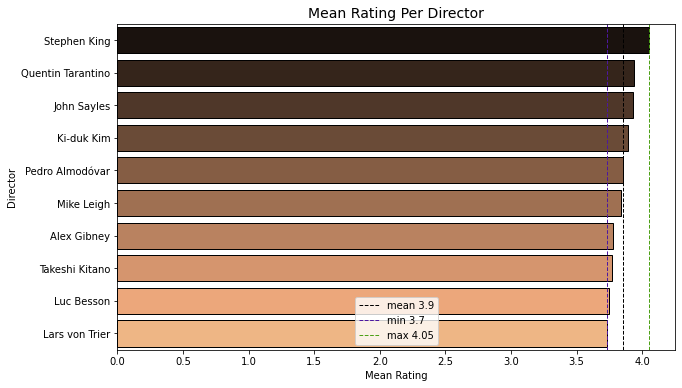

In [129]:
feat_popularity(directors.head(10), 'Director')

### Top 3 Directors with High ratings

<img height = "238" width = 178 src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ3ie6FvZbpJx2VbSMzbGsFagq2wPgnNXJxSPQVTI6ofqhWv28AZKCUZIt54kEQHr9gfiI&usqp=CAU" alt="Photo of Stephen King" class="GeneratedImage"> <img height = "238" width = 950 src="img\king.JPG" alt="Movies of Tom Hanks" class="GeneratedImage"></br>
<a href="https://en.wikipedia.org/wiki/Stephen_King">Stephen King</a>  is an American writer of books in the genres of horror, science fiction, fantasy, suspense, and paranormal fiction. </a>
</br>
</br>
<img height = "238" width = 178 src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQxlTrJvdxqSMBYf90USQe0qXEaMhXdy35FJOpUlEZ5PGl4wIBI" alt="Photo of Quentin Tarantino" class="GeneratedImage">  <img height = "238" width = 950 src="img\quent.JPG" alt="Movies of Tom Hanks" class="GeneratedImage"></br>
</br>
<a href="https://en.wikipedia.org/wiki/Quentin_Tarantino"> Quentin Tarantino</a> is an American director, actor, critic, novelist, and screenwriter. His movies are known for their extensive allusions to pop culture and movie history, nonlinear plots, grim comedy, stylised violence, long dialogue, widespread use of profanity, cameos, and ensemble casts. </a>
</br>
</br>

<img height = "238" width = 178 src="https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcSFu6ohQVsNtOaLKFv6Qv3Xbp2GCIx54HXeTKy0qnVOiZEp4IFT" alt="Photo of John Sayles" class="GeneratedImage">  <img height = "238" width = 950 src="img\jon.png" alt="Movies of Tom Hanks" class="GeneratedImage"></br>
<a href="https://en.wikipedia.org/wiki/Stephen_King">John Sayles</a>   is an American independent film director, screenwriter, editor, actor, and novelist. He has twice been nominated for the Academy Award for Best Original Screenplay, for Passion Fish and Lone Star. His film Men with Guns was nominated for the Golden Globe for Best Foreign Language Film.</a>
</br>
</br>

### Key observatios
* From the list above, we can see certain directors who are immediately recognized. Stephen King and Quentin Tarantino are, predictably, at the top of the list.
* It comes as no surprise that the director of the film with the highest rating, Shawshank Redemption, is ranked first.
* The fact that the top 3 directors have an average mean rating of 4.0 further demonstrates how positively moviegoers rank their favorite films.
---



### Again, in order to identify which directors are the least well-liked in terms of ratings, we must compute the mean rating for each.

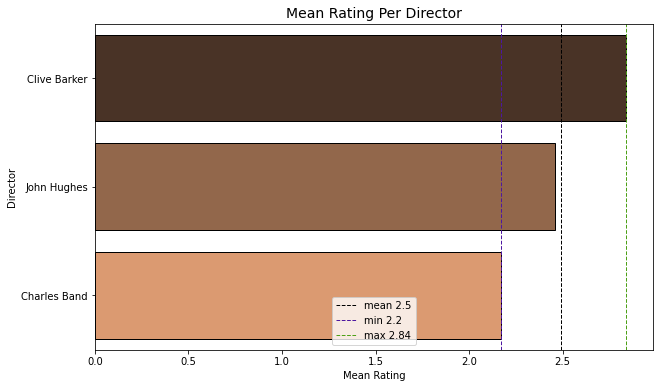

In [132]:
feat_popularity(directors.tail(3), 'Director')

### Top 3 Directors with the lowest ratings

<img height = "125" width = 125 src="https://www.thepitchkc.com/content/uploads/2021/11/g/r/charles-band-scaled-e1637002282929.jpg" alt="Photo of Charles Band" class="GeneratedImage"></br>
<a href="https://en.wikipedia.org/wiki/Charles_Band">Charles Band</a> is an American film producer and director, known for his work on horror comedy movies. </a>
</br>
</br>
<img height = "125" width = 125 src="https://upload.wikimedia.org/wikipedia/en/e/e3/John_Hughes_Home_Alone_2.jpg" alt="Photo of John Hughes" class="GeneratedImage"> 
</br>
<a href="https://en.wikipedia.org/wiki/John_Hughes_(filmmaker)"> John Hughes</a> was an American filmmaker. Hughes began his career in 1970 as an author of humorous essays and stories for the National Lampoon magazine. </a>
</br>
</br>

<img height = "125" width = 125 src="https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcQq8v6TWEuFEzwzeUmeVXsHWsR2nTst1wxrbHrSS77qnJMYtqog" alt="Photo of Clive Barker" class="GeneratedImage"></br>
<a href="https://en.wikipedia.org/wiki/Clive_Barker">Clive Barker</a>   is an English playwright, author, film director and visual artist who came to prominence in the mid-1980s with a series of short stories, the Books of Blood, which established him as a leading horror writer. He has since written many novels and other works. </a>
</br>
</br>

### Key observatios
* From the list above, we can notice a few filmmakers that stand out right away. Puppet Master was created by Charles band, which gets very poor reviews.

* The least popular directors have an average mean rating of 2.5, which further exemplifies how poorly viewers evaluate their movies.
---



#### Consumer perception of movie reviews or ratings

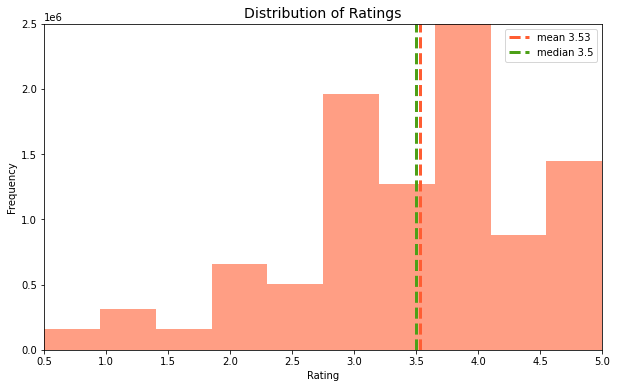

In [133]:
plt.figure(figsize=(10,6))
ax = sns.distplot(train['rating'],bins=10, kde=False, hist_kws=dict(alpha=0.6),color="#FF5D32")
mean = train['rating'].mean()
median = train['rating'].median()
plt.axvline(x=mean, label = f'mean {round(mean,2)}' , color='#FF5D32', lw=3, ls = '--')
plt.axvline(x=median, label = f'median {median}' , color='#4DA017', lw=3, ls = '--')
plt.xlim((0.5,5))
plt.ylim((0,2500000))
plt.title(f'Distribution of Ratings', fontsize=14)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Key point to note

 - The ratings' left-leaning bias is intriguing. An average distribution with a mean rating of 3.5 was anticipated. Instead, we see that viewers often give movies positive reviews and steer clear of giving them bad ones. The inclination of users to rank movies they like may help to explain this bias. In other words, it is unlikely that a person will finish watching and rating a film if they don't enjoy it.
---

### relationship between the number of ratings a movie has and how highly it is rated

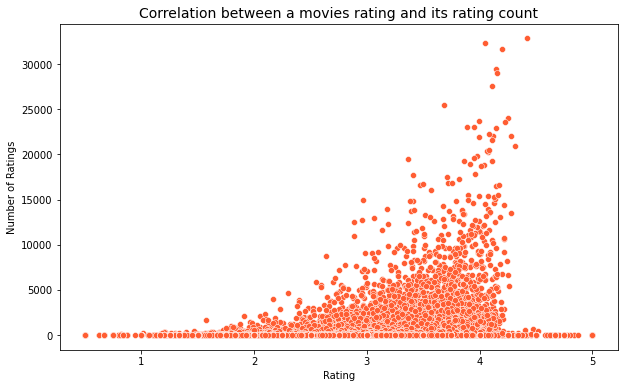

In [134]:
plt.figure(figsize=(10,6))
mean_ratings = train.groupby("movieId")['rating'].mean()
user_counts = train.groupby("movieId")['movieId'].count().values
sns.scatterplot(x=mean_ratings, y = user_counts, color="#FF5D32", )
plt.title(f'Correlation between a movies rating and its rating count', fontsize=14)
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

According to the scatter plot shown above, a movie is more likely to receive a high rating the more ratings it has. This supports our innate belief that moviegoers are more inclined to suggest a film to one another if it has a higher rating. In other words, most individuals aim to avoid making unfavorable suggestions.

### Percentage distribution of users per rating

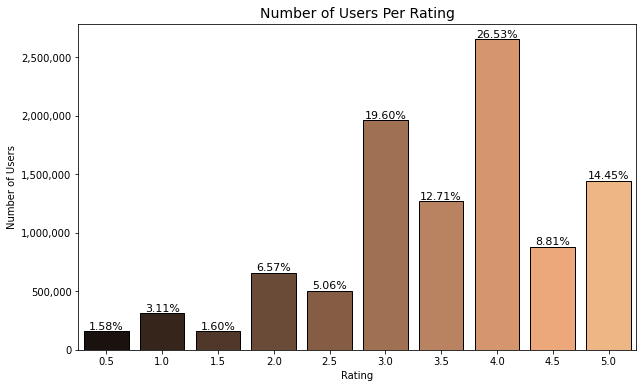

In [135]:
movieRatingDistGroup = train['rating'].value_counts().sort_index().reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=movieRatingDistGroup, x='index', y='rating', palette="copper", edgecolor="black", ax=ax)
ax.set_xlabel("Rating")
ax.set_ylabel('Number of Users')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+350, '{0:.2%}'.format(height/total), fontsize=11, ha="center", va='bottom')
plt.title('Number of Users Per Rating', fontsize=14)
plt.show()

We can see from the bar graph up top that the majority of movies receive a rating of 4.0.

#### 5.4 Top Movie Viewers
We're interested in finding out which userIds watch the most movies at this point. This information may be used to determine the top clients and their preferred movies.

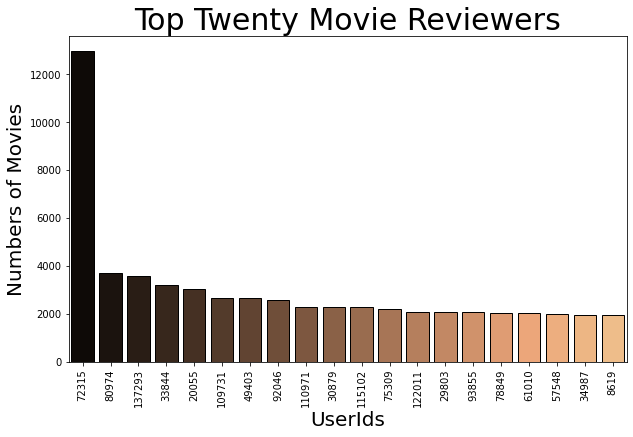

In [136]:
# Top movie viewers
train_table['userId'] = train_table['userId'].astype('str')
viewers = train_table['userId'].value_counts()
fig, ax = plt.subplots( figsize=(10,6))

ax = sns.barplot(y = viewers.values[:20], x = viewers.index[:20], palette='copper',edgecolor="black")
ax.set_xlabel("UserIds", fontsize = 20)
ax.set_ylabel("Numbers of Movies", fontsize = 20)
ax.set_title("Top Twenty Movie Reviewers", fontsize = 30)
plt.xticks(rotation=90, fontsize= 10)
plt.yticks( fontsize= 10)
plt.show()

**Top Movie Viewers by user ID**
- 72315
- 80974
- 137293


### Genres

retrieving features...
counting...
done!


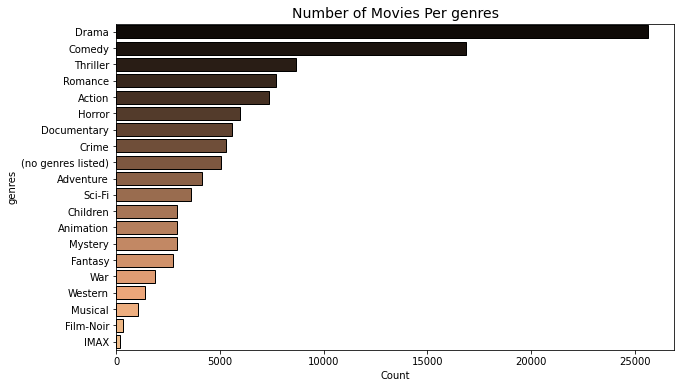

In [137]:
# Creat a dict to store values
movies = movies.dropna(axis=0)
genre_dict = {'genres': list(),
                'count': list(),}
# Retrieve a list of all possible genres
print('retrieving features...')
for movie in range((movies.shape[0])):
    gens = movies['genres'].iloc[movie].split('|')
    for gen in gens:
        if gen not in genre_dict['genres']:
            genre_dict['genres'].append(gen)
# count the number of occurences of each genre
print('counting...')
for genre in genre_dict['genres']:
    count = 0
    for movie in range((movies.shape[0])):
        gens = movies['genres'].iloc[movie].split('|')
        if genre in gens:
            count += 1
    genre_dict['count'].append(count)
    
    # Calculate metrics
genres = pd.DataFrame(genre_dict)
print('done!')
df = genres.sort_values(by = 'count', ascending=False)
plt.figure(figsize=(10,6))
ax = sns.barplot(y = df['genres'], x = df['count'], palette='copper', orient='h',edgecolor="black")
plt.title('Number of Movies Per genres', fontsize=14)
plt.ylabel('genres')
plt.xlabel('Count')
plt.show()

#### Key point to consider
- Drama, comedy, and thriller are the top 3 movie genres in popularity.
Character, story, storyline, and setting are the four constituent aspects or pieces of a genre. Additionally, it's common to hear individuals say that a certain movie had a solid storyline or an interesting tale. in reality the characters, the issues/conflicts the characters encountered, and the resolution of those issues and conflicts are what people are really referring to. Drama may be the most popular genre since it focuses on character development in the story, frequently overcoming a variety of obstacles and conflicts, or human challenges.

- Drama provides the emotional and interpersonal growth of realistic individuals in a realistic context, according to Hayley Mckenzie. It delivers an openly depicted tale of human adversity and provides rich character development. And this may be the main factor behind the popularity of the drama genre.

- Approximately 5000 movies have missing genres.

- We can use the IMDB and TMDB ID's together with the APIs to fill missing data. Further, IMAX is not a genre but rather a proprietary system for mass-viewings.
---

### The above figure does not tell us anything about the popularity of the genres, lets calculate a mean rating and append it to the data

In [138]:
def mean_calc(feat_df, ratings = train, movies = movies, metadata = imdb_data, column = 'genres'):
    mean_ratings = pd.DataFrame(ratings.merge(movies, how='left').groupby(['movieId'])['rating'].mean())
    movie_eda = movies.copy()
    movie_eda = movie_eda.join(mean_ratings, on = 'movieId', how = 'left')

    # Exclude missing values
    movie_eda = movie_eda
    movie_eda2 = movie_eda[movie_eda['rating'].notnull()]

    means = []
    for feat in feat_df[f'{column}']:
        mean = round(movie_eda2[movie_eda2[f'{column}'].str.contains(feat)]['rating'].mean(),2)
        means.append(mean)
    return means
genres['mean_rating'] = mean_calc(genres)
genres.sort_values('mean_rating', ascending=False).head(5)

,genres,count,mean_rating
14,Documentary,5605,3.40
18,Film-Noir,353,3.33
15,War,1874,3.29
13,IMAX,195,3.25
6,Drama,25606,3.21


In [139]:
def genre_popularity(df):
    """
    Plots the mean rating per genre.
    """
    count_filt = 500
    plt.figure(figsize=(10,6))
    plot_data = df[df['count']>count_filt]
    mean = plot_data['mean_rating'].mean()
    min_ = plot_data['mean_rating'].min()
    max_ = plot_data['mean_rating'].max()
    sns.barplot(y = plot_data['genres'], x = plot_data['mean_rating'], order = plot_data['genres'], orient='h',palette='copper')
    plt.axvline(x=mean, label = f'mean {round(mean,1)}' , color='blue', lw=1, ls ='--')
    plt.axvline(x=min_, label = f'min {round(min_,1)}' , color='#FF5D32', lw=1, ls = '--')
    plt.axvline(x=max_, label = f'max {max_}' , color='r', lw=1,ls = '--')
    plt.title(f'Mean Rating Per Genre', fontsize=14)
    plt.ylabel('Genre')
    plt.xlabel('Mean Rating')
    plt.legend(loc='lower center')
    plt.show()

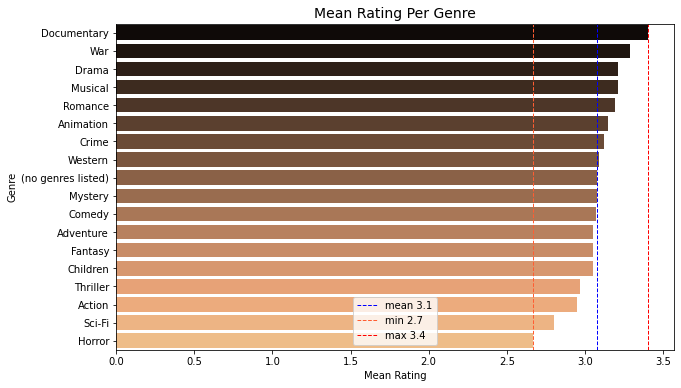

In [140]:
genre_popularity(genres.sort_values('mean_rating', ascending=False))

#### Observations
<img height = "210" width = 400 src="https://imgix.bustle.com/fatherly/2019/06/best-nature-documentaries.jpg?w=1200&h=630&fit=crop&crop=faces&fm=jpg" align="center" alt="Photo of Clive Barker" class="GeneratedImage"></br>

- Documentries seams to be the most higly rated releases in the data

- The ratings are almost evenly distributed, with the exception of documentaries, conflict, drama, musicals, and romance, which score over average. On the other side, the ratings for thriller, action, science fiction, and horror are noticeably below average.

- Hollywood crime dramas are referred to as "film-noir," especially those that stress cynical attitudes and sexual desires. In general, the "classic era" of American film-noir is thought to have been the 1940s and 1950s. Though it's possible that their particular audience is why some films earn the greatest ratings. For IMAX movies, the same reasoning holds true; hence, we only accounted for categories with a count of 500 or more in this graph.

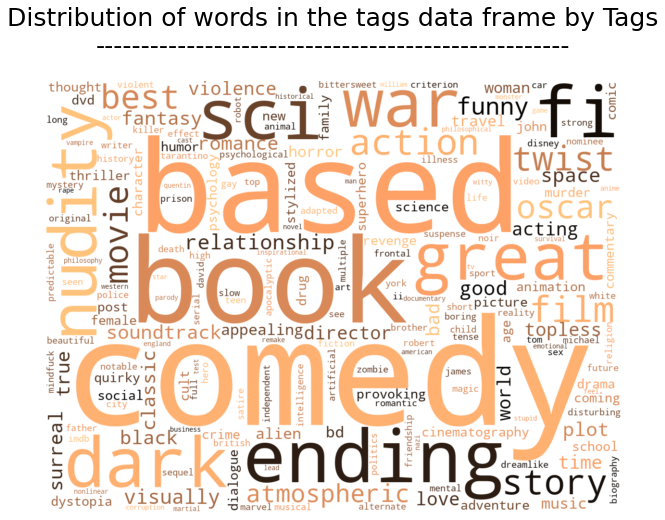

In [141]:
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in tags['tag']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range((np.shape(tokens)[0])):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width=1200, height=900,
                      colormap='copper',
                      background_color='white',
                      stopwords=stopwords,collocations=False,
                      min_font_size=10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize=(14, 7), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Distribution of words in the tags data frame by Tags\n----------------------------------------------------',fontsize=25,y=1.05 ,loc='center')
plt.tight_layout(pad=0)

plt.show()


<a id="four"></a>
## 6. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |


---

**Data(Feature) Engineering** is the process of using domain knowledge to reconfigure the data and create “features” that optimize machine learning algorithms. With the insight gained from the **EDA** section above, we have decided to work with the below listed table:
- train
- test
- movies
- imdb_data

Also, for this phase we shall execute the below task on our dataset:
- Identify the unique userIds in the test data and only work with same for the purpose of **Content-based** algorithm
- Sort both the train and test dataset by userId for both algorithms
- Merge the movie and imdb_data tables separately with both the test and train dataset, for both algorithms 
- Drop unwanted columns after the merge
- Generate a key word column, which is a collection of all vital features of a movie for **conten-based** algorithm
- Divide the dataset set into chunks of 162,350( unique userId per chunk), to ease data processing acivities like vectorization and evaluation of cosine_similarity

### Multidimensional Scaling
Multidimensional scaling (MDS) is a technique for visualizing distances between objects on a map, where the distance is known between pairs of the objects.  
> "The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked, whilst dissimilar points have an extremely small probability of being picked. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the two distributions with respect to the locations of the points in the map. Note that whilst the original algorithm uses the Euclidean distance between objects as the base of its similarity metric, this should be changed as appropriate." [[3]](#ref3)

In [6]:
# Subset the data to cut down computation time for now
genome_score = genome_scores[:10000000]

In [7]:
# # Although scores are in the range of 0-1, there is no harm in scaling
# scaler_mds = StandardScaler()
# mds_genome = scaler_mds.fit_transform(genome_score.sample(frac=0.0001))

In [8]:
tsne = TSNE(3, n_jobs = -1, verbose = 2, perplexity = 10, learning_rate = 0.1)

In [9]:
tsne.fit(genome_score)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10000000 samples in 18.108s...
[t-SNE] Computed neighbors for 10000000 samples in 107.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000000
[t-SNE] Computed conditional probabilities for sample 11000 / 10000000
[t-SNE] Computed conditional probabilities for sample 12000 / 10000000
[t-SN

MemoryError: Unable to allocate 4.62 GiB for an array with shape (620000000,) and data type float64